In [13]:
%%time
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
from dataclasses import dataclass
from pathlib import Path

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd


@dataclass
class Config:
    project_dir: Path = Path("../../")
    model_dir: Path = project_dir / "models"
    outputs_dir: Path = project_dir / "outputs"
    data_dir: Path = project_dir / "data"
    raw_dir: Path = data_dir / "raw"
    interim_dir: Path = data_dir / "interim"
    processed_dir: Path = data_dir / "processed"
    results_dir: Path = project_dir / "results"
    results_agg_dir: Path = results_dir / "agg"
    results_figs_dir: Path = results_dir / "figs"


config = Config()
sys.path.append(str(config.project_dir.resolve()))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CPU times: user 1.32 ms, sys: 1.76 ms, total: 3.08 ms
Wall time: 3.18 ms


In [3]:
df_orders = pd.read_csv(config.interim_dir / "olist_orders_customer_merged.csv")
df_orders["order_purchase_timestamp"] = pd.to_datetime(
    df_orders["order_purchase_timestamp"]
)

df_item_products = pd.read_csv(
    config.interim_dir / "olist_item_product_seller_merged.csv"
)
df_sales = pd.merge(
    df_orders[["order_id", "order_purchase_timestamp"]],
    df_item_products[["order_id", "price"]],
    on="order_id",
    how="left",
)

## 月毎の集計

### オーダー数

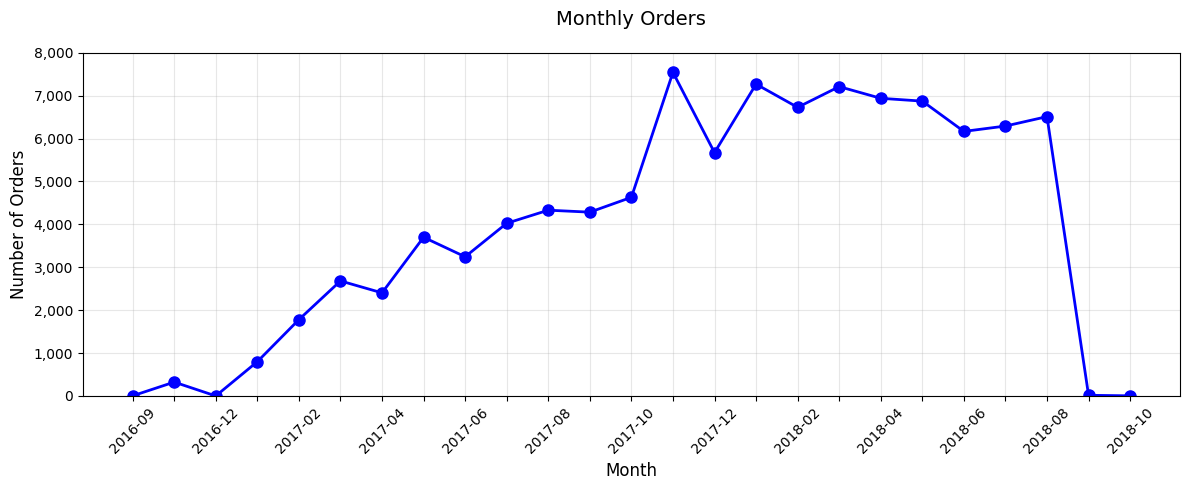

In [39]:
date_range = pd.period_range(start="2016-09", end="2018-10", freq="M")

# 月毎のオーダー数を集計し、欠損月を0で埋める
monthly_orders = (
    df_orders.groupby(df_orders["order_purchase_timestamp"].dt.to_period("M"))[
        "order_id"
    ]
    .count()
    .reset_index(name="count")
)

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(
    monthly_orders["order_purchase_timestamp"].astype(str),
    monthly_orders["count"],
    marker="o",
    linewidth=2,
    markersize=8,
    color="blue",
)
ax.grid(True, alpha=0.3)
ax.set_title("Monthly Orders", pad=20, fontsize=14)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Number of Orders", fontsize=12)
ax.tick_params(axis="x", rotation=45)

# x軸のラベルを2ヶ月おきに表示
x_labels = monthly_orders["order_purchase_timestamp"].astype(str)
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(
    [label if i % 2 == 0 else "" for i, label in enumerate(x_labels)], rotation=45
)

ax.set_ylim(0, 8000)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{int(x):,}"))
plt.tight_layout()
plt.savefig(config.results_figs_dir / "monthly_orders.png")

### 売り上げ

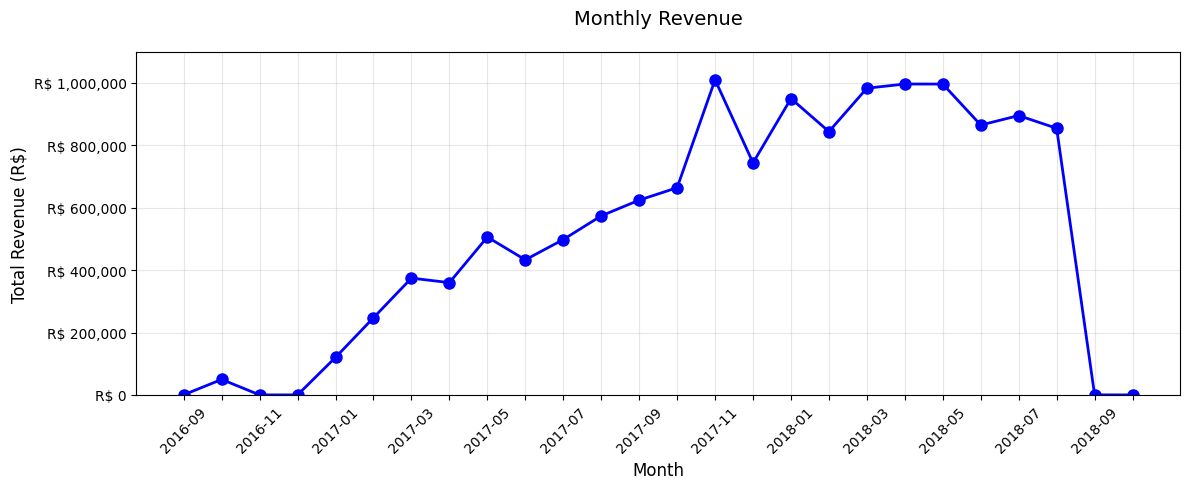

In [ ]:
date_range = pd.period_range(start="2016-09", end="2018-10", freq="M")

# 月毎の売上を集計し、欠損月を0で埋める
monthly_revenue = (
    df_sales.groupby(df_sales["order_purchase_timestamp"].dt.to_period("M"))["price"]
    .sum()
    .reindex(date_range, fill_value=0)
    .reset_index(name="total_revenue")
)

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(
    monthly_revenue["index"].astype(str),
    monthly_revenue["total_revenue"],
    marker="o",
    linewidth=2,
    markersize=8,
    color="blue",
)
ax.grid(True, alpha=0.3)
ax.set_title("Monthly Revenue", pad=20, fontsize=14)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Total Revenue (R$)", fontsize=12)

# x軸のラベルを2ヶ月おきに表示
x_labels = monthly_revenue["index"].astype(str)
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(
    [label if i % 2 == 0 else "" for i, label in enumerate(x_labels)], rotation=45
)

ax.set_ylim(0, 1100000)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"R$ {x:,.0f}"))
plt.tight_layout()
plt.savefig(config.results_figs_dir / "monthly_revenue")

### 利用者数

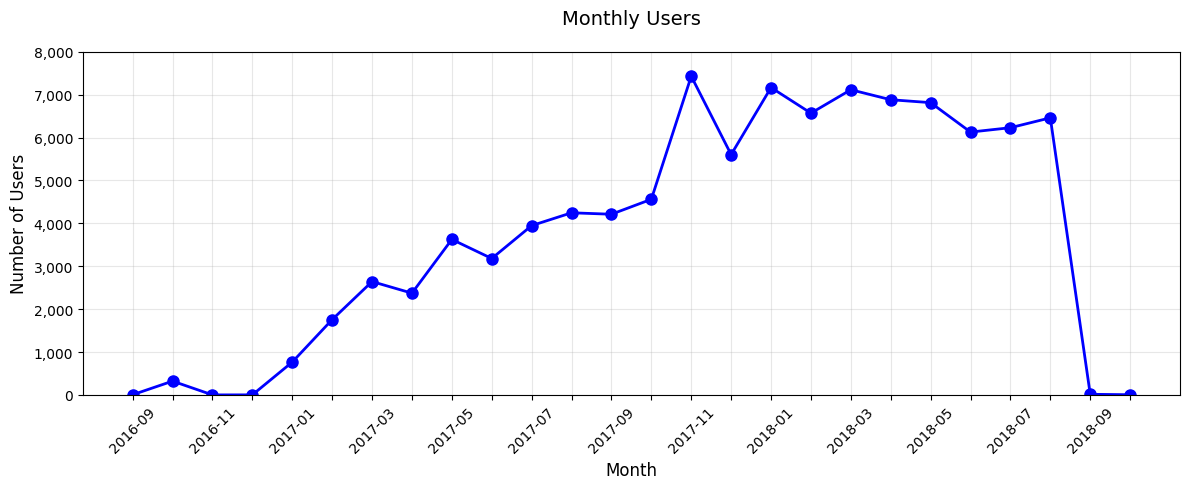

In [41]:
date_range = pd.period_range(start="2016-09", end="2018-10", freq="M")
# 月毎のユニークユーザー数を集計
monthly_users = (
    df_orders.groupby(df_orders["order_purchase_timestamp"].dt.to_period("M"))
    .agg({"customer_unique_id": "nunique"})
    .reindex(date_range, fill_value=0)
    .reset_index()
)
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(
    monthly_users["index"].astype(str),
    monthly_users["customer_unique_id"],
    marker="o",
    linewidth=2,
    markersize=8,
    color="blue",
)
ax.grid(True, alpha=0.3)
ax.set_title("Monthly Users", pad=20, fontsize=14)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Number of Users", fontsize=12)
ax.tick_params(axis="x", rotation=45)

# x軸のラベルを2ヶ月おきに表示
x_labels = monthly_users["index"].astype(str)
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(
    [label if i % 2 == 0 else "" for i, label in enumerate(x_labels)], rotation=45
)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{int(x):,}"))
ax.set_ylim(0, 8000)
plt.tight_layout()
plt.savefig(config.results_figs_dir / "monthly_users.png")
plt.show()

### 販売者数

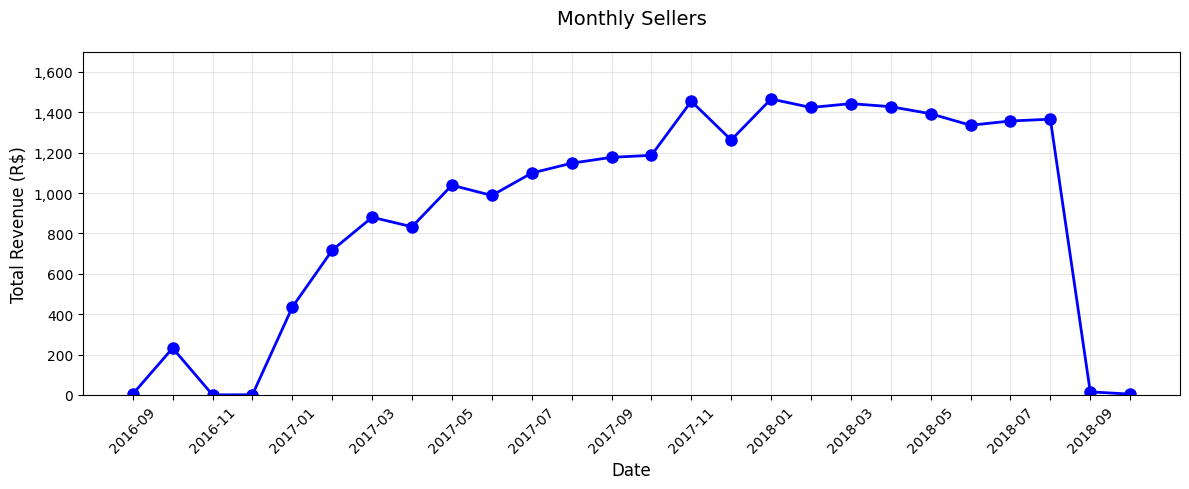

In [69]:
date_range = pd.period_range(start="2016-09", end="2018-10", freq="M")
df_order_seller_merged = pd.merge(
    df_orders,
    df_item_products[["order_id", "seller_id"]].drop_duplicates(),
    on="order_id",
    how="left",
)
monthly_seller_counts = (
    df_order_seller_merged.groupby(
        df_orders["order_purchase_timestamp"].dt.to_period("M")
    )["seller_id"]
    .nunique()
    .reindex(date_range, fill_value=0)
    .reset_index(name="seller_count")
)

fig, ax = plt.subplots(1, 1, figsize=(12, 5))

ax.plot(
    monthly_seller_counts["index"].astype(str),
    monthly_seller_counts["seller_count"],
    marker="o",
    linewidth=2,
    markersize=8,
    color="blue",
)
ax.grid(True, alpha=0.3)
ax.set_title("Monthly Sellers", pad=20, fontsize=14)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Total Revenue (R$)", fontsize=12)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{int(x):,}"))
x_labels = monthly_seller_counts["index"].astype(str)
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(
    [label if i % 2 == 0 else "" for i, label in enumerate(x_labels)], rotation=45
)
ax.set_ylim(0, 1700)
ax.tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.savefig(config.results_figs_dir / "monthly_sellers.png")
plt.show()


## 日毎の集計

/var/folders/30/20s46n1s20jdzzh6w9vnkglw0000gn/T/ipykernel_70917/3596694208.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(
/var/folders/30/20s46n1s20jdzzh6w9vnkglw0000gn/T/ipykernel_70917/3596694208.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(
/var/folders/30/20s46n1s20jdzzh6w9vnkglw0000gn/T/ipykernel_70917/3596694208.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(


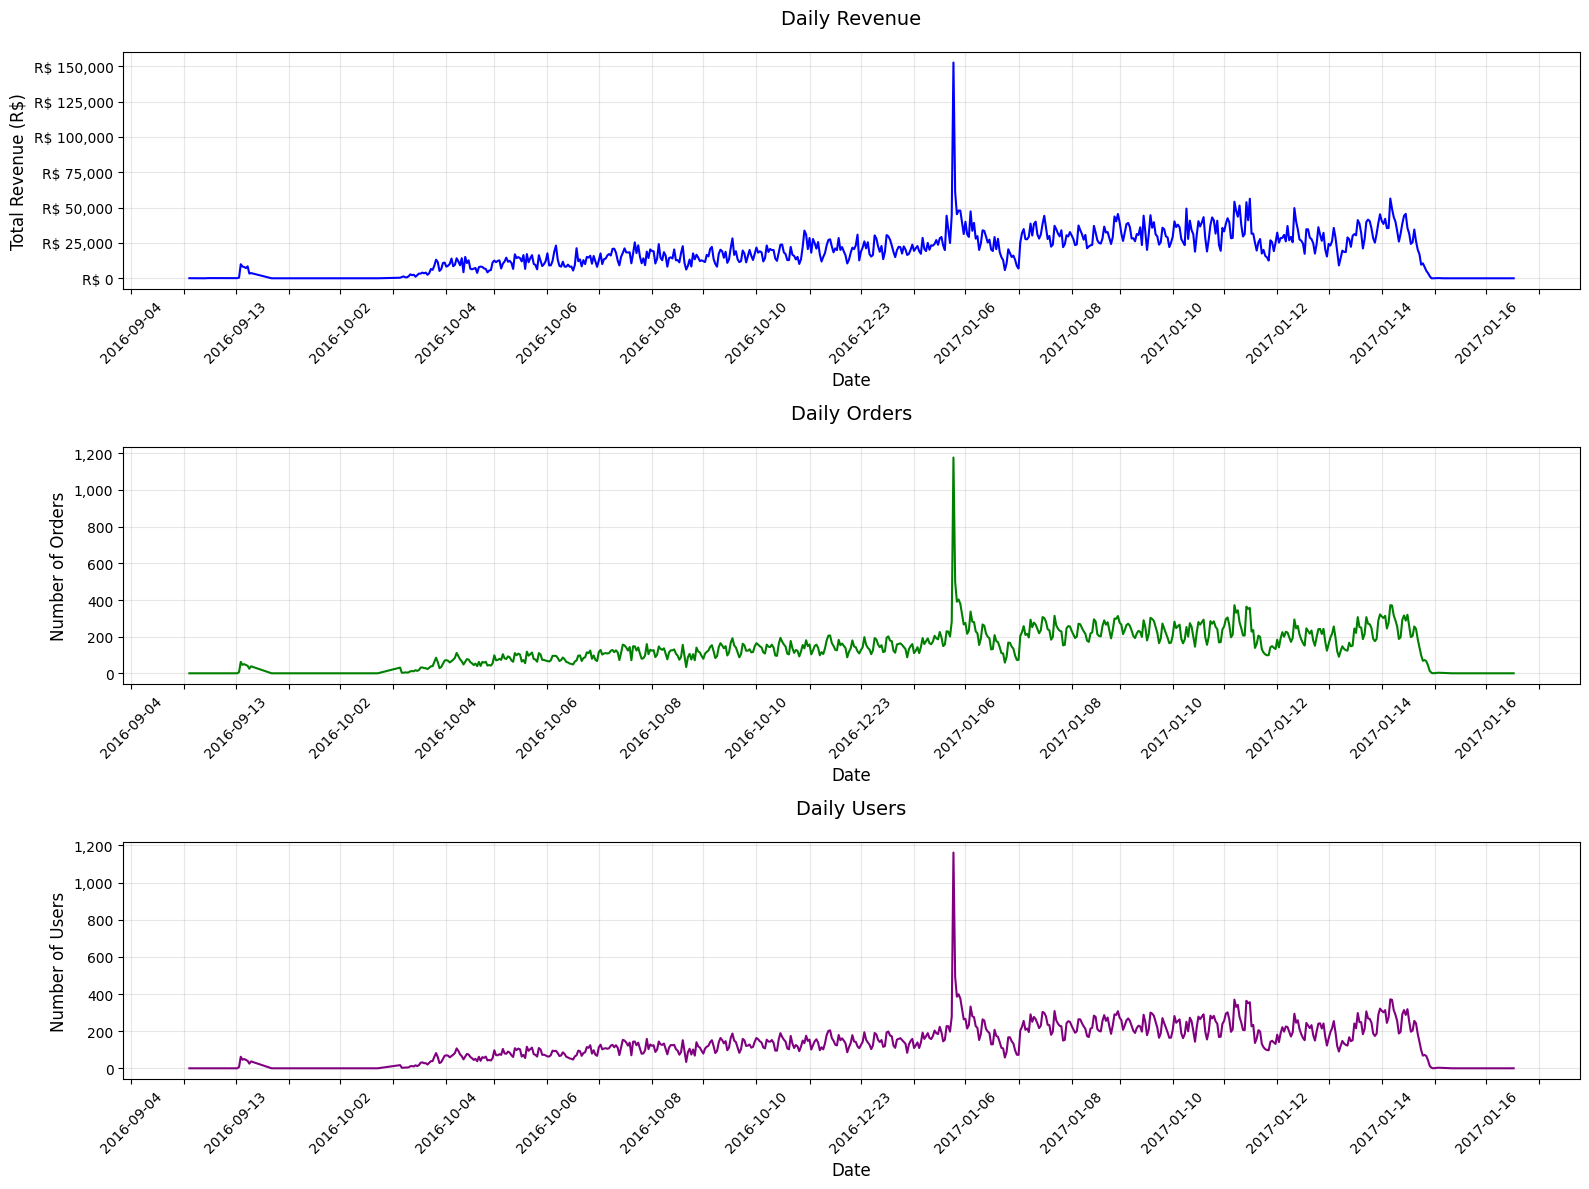

In [64]:
# 日次で集計
daily_orders = (
    df_orders.groupby(df_orders["order_purchase_timestamp"].dt.date)["order_id"]
    .count()
    .reset_index(name="count")
)

# 日次の売上集計
daily_revenue = (
    df_sales.groupby(df_sales["order_purchase_timestamp"].dt.date)["price"]
    .sum()
    .reset_index(name="total_revenue")
)

# 日次のユニークユーザー数集計
daily_users = (
    df_orders.groupby(df_orders["order_purchase_timestamp"].dt.date)
    .agg({"customer_unique_id": "nunique"})
    .reset_index()
)

# グラフ描画
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# 1. Daily Revenue (売上)
axes[0].plot(
    daily_revenue["order_purchase_timestamp"],
    daily_revenue["total_revenue"],
    marker="",
    linewidth=1.5,
    color="blue",
)
axes[0].grid(True, alpha=0.3)
axes[0].set_title("Daily Revenue", pad=20, fontsize=14)
axes[0].set_xlabel("Date", fontsize=12)
axes[0].set_ylabel("Total Revenue (R$)", fontsize=12)

locator = mdates.MonthLocator(interval=1)
formatter = mdates.DateFormatter("%Y-%m")
axes[0].xaxis.set_major_locator(locator)
axes[0].xaxis.set_major_formatter(formatter)
axes[0].tick_params(axis="x", rotation=45)
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"R$ {x:,.0f}"))

# 2. Daily Sales (注文数)
axes[1].plot(
    daily_orders["order_purchase_timestamp"],
    daily_orders["count"],
    marker="",
    linewidth=1.5,
    color="green",
)
axes[1].grid(True, alpha=0.3)
axes[1].set_title("Daily Orders", pad=20, fontsize=14)
axes[1].set_xlabel("Date", fontsize=12)
axes[1].set_ylabel("Number of Orders", fontsize=12)
axes[1].xaxis.set_major_locator(locator)
axes[1].xaxis.set_major_formatter(formatter)
axes[1].tick_params(axis="x", rotation=45)
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{int(x):,}"))

# 3. Daily Users (ユニークユーザー数)
axes[2].plot(
    daily_users["order_purchase_timestamp"],
    daily_users["customer_unique_id"],
    marker="",
    linewidth=1.5,
    color="purple",
)
axes[2].grid(True, alpha=0.3)
axes[2].set_title("Daily Users", pad=20, fontsize=14)
axes[2].set_xlabel("Date", fontsize=12)
axes[2].set_ylabel("Number of Users", fontsize=12)
axes[2].xaxis.set_major_locator(locator)
axes[2].xaxis.set_major_formatter(formatter)
axes[2].tick_params(axis="x", rotation=45)
axes[2].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{int(x):,}"))
for i in range(3):
    axes[i].set_xticklabels(
        [label if i % 2 == 0 else "" for i, label in enumerate(x_labels)], rotation=45
    )
plt.tight_layout()
plt.savefig(config.results_figs_dir / "daily_data.png")
plt.show()